In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import sklearn as skl
import statsmodels.formula.api as smf
import statsmodels as sm
sns.set()

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
new_df = df.loc[df['Country/Region']=='Singapore']
singa_df = new_df.drop(['Province/State','Country/Region','Lat','Long','1/22/20'], axis=1)
singa = singa_df.T

In [3]:
new_columns = []
df2 = pd.DataFrame()

for i in range(len(singa_df.columns)):
    new_columns.append('Yt'+'{}'.format(i))
    df2 = pd.concat([df2, singa.shift(i)],axis =1)
df2.columns = new_columns

In [5]:
df2 = df2.rename({'Yt0':'Yt'},axis=1)

In [7]:
df2 = df2.fillna(0)
df2 = df2.assign(days=range(len(df2.index)))
df2

,Yt,Yt1,Yt2,Yt3,Yt4,Yt5,Yt6,Yt7,Yt8,Yt9,...,Yt809,Yt810,Yt811,Yt812,Yt813,Yt814,Yt815,Yt816,Yt817,days
1/23/20,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1/24/20,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1/25/20,3,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1/26/20,4,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1/27/20,5,4.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4/15/22,1155581,1152177.0,1148656.0,1145121.0,1140569.0,1138001.0,1135428.0,1132169.0,1128155.0,1123886.0,...,5.0,4.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,813
4/16/22,1157251,1155581.0,1152177.0,1148656.0,1145121.0,1140569.0,1138001.0,1135428.0,1132169.0,1128155.0,...,7.0,5.0,4.0,3.0,3.0,1.0,0.0,0.0,0.0,814
4/17/22,1160300,1157251.0,1155581.0,1152177.0,1148656.0,1145121.0,1140569.0,1138001.0,1135428.0,1132169.0,...,7.0,7.0,5.0,4.0,3.0,3.0,1.0,0.0,0.0,815
4/18/22,1162780,1160300.0,1157251.0,1155581.0,1152177.0,1148656.0,1145121.0,1140569.0,1138001.0,1135428.0,...,10.0,7.0,7.0,5.0,4.0,3.0,3.0,1.0,0.0,816


# Neural Network

## Part A : Fit the model on all of A and apply it to all A

### 2 Hidden Nodes

In [11]:
x_all = torch.from_numpy(df2.iloc[:,1:818].values)
y_all = torch.from_numpy(df2.Yt.values)

#normalize x value and turn y value to log of y
y_all = torch.log(y_all)
x_all = torch.nn.functional.normalize(x_all)

In [12]:
x_all = x_all.float()
y_all = y_all.float()
y_all = y_all.unsqueeze(1)

In [13]:
[x_all.shape, 
 y_all.shape,
 ]

[torch.Size([818, 817]), torch.Size([818, 1])]

In [14]:
H = 2 # two hidden nodes for 1 hidden layer
D_in = x_all.size()[1]
D_out = 1
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

loss_fn = torch.nn.MSELoss(reduction='mean')

In [15]:
# n = df2.shape[0]
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)

for t in range(100000):
    y_pred = model(x_all)
    
    loss = loss_fn(y_pred, y_all)
    if t % 10000 == 0:
        # print(t, loss.item()/n)
        print(t, loss.item())
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()

0 132.92779541015625
10000 127.90796661376953
20000 123.07422637939453
30000 118.42118835449219
40000 113.93579864501953
50000 109.600830078125
60000 105.393798828125
70000 101.2841567993164
80000 97.22860717773438
90000 93.16439819335938


In [16]:
# get predicted y value and true y value in numpy format (log of y)
ytest = model(x_all).detach().numpy().reshape(-1)
y_original = y_all.detach().numpy().reshape(-1)

/opt/tljh/user/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

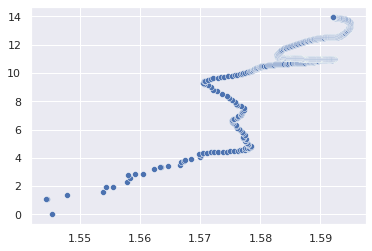

In [17]:
sns.scatterplot(ytest,y_original)

Text(0, 0.5, 'Prediction Error')

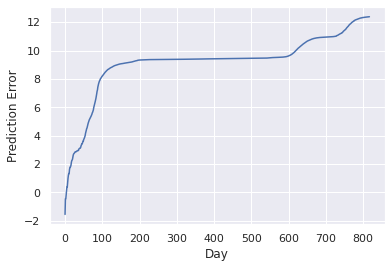

In [18]:
plt.plot(df2['days'],y_original-ytest)  # y_original is the outcome and ytest is the predicted outcome (on the scale of log y)
plt.xlabel('Day')
plt.ylabel('Prediction Error')

## 4 Hidden nodes over 2 layers with 2 hidden nodes in each layer 

In [21]:
H2 = 2 # two hidden nodes for each hidden layer 
D_in2 = x_all.size()[1]
D_out2 = 1
model2 = torch.nn.Sequential(
    torch.nn.Linear(D_in2, H2),     #two hidden layer
    torch.nn.ReLU(),
    torch.nn.Linear(H2, H2),
    torch.nn.ReLU(),
    torch.nn.Linear(H2, D_out2),
)

loss_fn = torch.nn.MSELoss(reduction='mean')

In [22]:
optimizer = torch.optim.SGD(model2.parameters(), lr=1e-3)

for t in range(100000):
    y_pred2 = model2(x_all)
    
    loss = loss_fn(y_pred2, y_all)
    if t % 10000 == 0:
        # print(t, loss.item()/n)
        print(t, loss.item())
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()

0 112.61164093017578
10000 1.5609350204467773
20000 0.9356819987297058
30000 0.7691906094551086
40000 0.757876992225647
50000 0.7543185949325562
60000 0.7524374723434448
70000 0.7510606646537781
80000 0.7499088048934937
90000 0.7488925457000732


In [23]:
ytest2 = model2(x_all).detach().numpy().reshape(-1) # y_original2 is the outcome and ytest2 is the predicted outcome (on the scale of log y)
y_original2 = y_all.detach().numpy().reshape(-1)

/opt/tljh/user/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

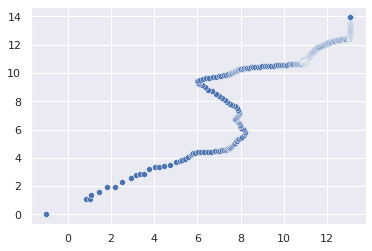

In [24]:
sns.scatterplot(ytest2,y_original)

Text(0, 0.5, 'Prediction Error')

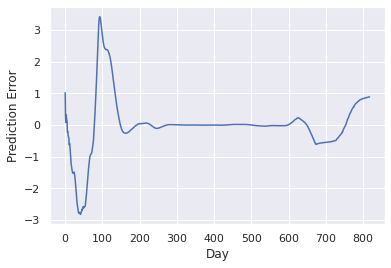

In [25]:
plt.plot(df2['days'],y_original2-ytest2)  # y_original is the outcome and ytest is the predicted outcome (on the scale of log y)
plt.xlabel('Day')
plt.ylabel('Prediction Error')

## Regression using pytorch

In [52]:
D_in = x_all.size()[1]
D_out = 1
modelr1 = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
)

loss_fn = torch.nn.MSELoss(reduction='mean')

In [53]:
# n = df2.shape[0]
optimizer = torch.optim.SGD(modelr1.parameters(), lr=1e-6)

for t in range(100000):
    y_pred = modelr1(x_all)
    
    loss = loss_fn(y_pred, y_all)
    if t % 10000 == 0:
        # print(t, loss.item()/n)
        print(t, loss.item())
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()

0 120.84754180908203
10000 113.02153015136719
20000 105.71349334716797
30000 98.88899230957031
40000 92.5162582397461
50000 86.5653076171875
60000 81.00822448730469
70000 75.81873321533203
80000 70.97276306152344
90000 66.4471206665039


In [54]:
ytestr1 = modelr1(x_all).detach().numpy().reshape(-1)
y_originalr1 = y_all.detach().numpy().reshape(-1)

Text(0, 0.5, 'Prediction Error')

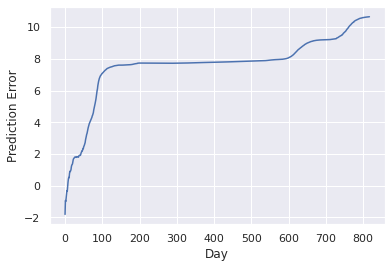

In [56]:
plt.plot(df2['days'],y_originalr1-ytestr1)  # y_original is the outcome and ytest is the predicted outcome (on the scale of log y)
plt.xlabel('Day')
plt.ylabel('Prediction Error')

In [57]:
np.square(np.subtract(y_originalr1,ytestr1)).mean()

62.22105

# Part b Half Data and fit to all 

## 2 hidden nodes 

In [28]:
x_half = torch.from_numpy(df2.iloc[0:410,1:410].values)
y_half = torch.from_numpy(df2.iloc[0:410,0].values)

# normalize x and change y to log of y 
y_half = torch.log(y_half)
x_half = torch.nn.functional.normalize(x_half)

x_half = x_half.float()
y_half = y_half.float()

y_half = y_half.unsqueeze(1)

In [29]:
[x_half.shape, 
 y_half.shape,
 ]

[torch.Size([410, 409]), torch.Size([410, 1])]

In [30]:
# test set: all of A 
x_testb = torch.from_numpy(df2.iloc[:,1:410].values)
y_testb = torch.from_numpy(df2.iloc[:,0].values)
y_testb = torch.log(y_testb)
x_testb = torch.nn.functional.normalize(x_testb)

x_testb = x_testb.float()
y_testb = y_testb.float()

y_testb = y_testb.unsqueeze(1)

In [31]:
[x_testb.shape, 
 y_testb.shape,
 ]

[torch.Size([818, 409]), torch.Size([818, 1])]

In [32]:
H = 2  # two hidden nodes
D_in = x_half.size()[1]
D_out = 1
modelb1 = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),       # one hidden layer
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

loss_fn = torch.nn.MSELoss(reduction='mean')

# n = df2.shape[0]
optimizer = torch.optim.SGD(modelb1.parameters(), lr=1e-6)

for t in range(100000):
    y_pred = modelb1(x_half)
    
    loss = loss_fn(y_pred, y_half)
    if t % 10000 == 0:
        # print(t, loss.item()/n)
        print(t, loss.item())
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()


0 97.72466278076172
10000 94.1121826171875
20000 90.66416931152344
30000 87.34730529785156
40000 84.10338592529297
50000 80.9646987915039
60000 77.91947937011719
70000 74.94306182861328
80000 72.00749969482422
90000 69.0763931274414


In [33]:
ypredb1 = modelb1(x_testb).detach().numpy().reshape(-1)    # y_originalb1 is the outcome and yredb1 is the predicted outcome (on the scale of log y)
y_originalb1 = y_testb.detach().numpy().reshape(-1)

/opt/tljh/user/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

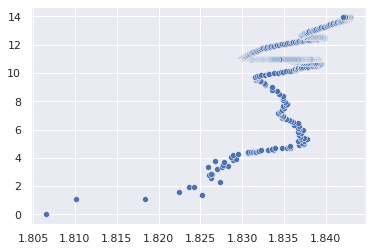

In [34]:
sns.scatterplot(ypredb1,y_originalb1)

Text(0, 0.5, 'Forecasting Error')

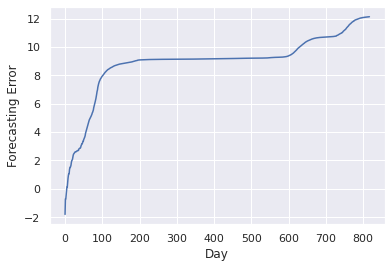

In [35]:
plt.plot(df2['days'],y_originalb1-ypredb1)  # y_originalb1 is the outcome and ypredb1 is the predicted outcome (on the scale of log y)
plt.xlabel('Day')
plt.ylabel('Forecasting Error')

In [36]:
np.square(np.subtract(y_originalb1,ypredb1)).mean()

84.51569

## 4 Hidden nodes over 2 layers with 2 hidden nodes in each layer 

In [37]:
# train the model
H2 = 2    # two hidden nodes 
D_in2 = x_half.size()[1]
D_out2 = 1
modelb2 = torch.nn.Sequential(
    torch.nn.Linear(D_in2, H2),
    torch.nn.ReLU(),
    torch.nn.Linear(H2, H2),            # two hidden layer
    torch.nn.ReLU(),
    torch.nn.Linear(H2, D_out2),
)

loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.SGD(modelb2.parameters(), lr=1e-3)

for t in range(100000):
    y_pred2 = modelb2(x_half)
    
    loss = loss_fn(y_pred2, y_half)
    if t % 10000 == 0:
        # print(t, loss.item()/n)
        print(t, loss.item())
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()




0 110.47624206542969
10000 1.440015196800232
20000 1.2820998430252075
30000 1.1959565877914429
40000 1.1155965328216553
50000 1.0203933715820312
60000 0.9107332825660706
70000 0.7960367202758789
80000 0.6921255588531494
90000 0.6047411561012268


In [38]:
# test the model
ypredb2 = modelb2(x_testb).detach().numpy().reshape(-1)   # y_originalb2 is the outcome and ypredb2 is the predicted outcome (on the scale of log y)
y_originalb2 = y_testb.detach().numpy().reshape(-1)

/opt/tljh/user/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

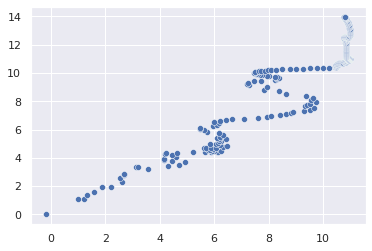

In [39]:
sns.scatterplot(ypredb2,y_originalb2)

Text(0, 0.5, 'Forecasting Error')

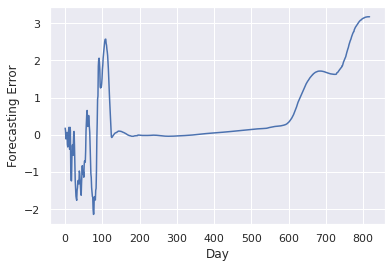

In [40]:
plt.plot(df2['days'],y_originalb2-ypredb2)  # y_originalb2 is the outcome and ypredb2 is the predicted outcome (on the scale of log y)
plt.xlabel('Day')
plt.ylabel('Forecasting Error')

In [41]:
np.square(np.subtract(y_originalb2,ypredb2)).mean()

1.3438625

## Regression using Pytorch

In [49]:
# train the model
D_in2 = x_half.size()[1]
D_out2 = 1
modelr2 = torch.nn.Sequential(
    torch.nn.Linear(D_in2, D_out2),
)

loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.SGD(modelr2.parameters(), lr=1e-3)

for t in range(100000):
    y_pred2 = modelr2(x_half)
    
    loss = loss_fn(y_pred2, y_half)
    if t % 10000 == 0:
        # print(t, loss.item()/n)
        print(t, loss.item())
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()





0 98.67102813720703
10000 1.7212870121002197
20000 1.5940696001052856
30000 1.544020652770996
40000 1.5169875621795654
50000 1.4996953010559082
60000 1.4872303009033203
70000 1.4774290323257446
80000 1.4692705869674683
90000 1.462234377861023


In [50]:
# test the model
ypredr2 = modelr2(x_testb).detach().numpy().reshape(-1)   # y_originalb2 is the outcome and ypredb2 is the predicted outcome (on the scale of log y)
y_originalr2 = y_testb.detach().numpy().reshape(-1)

Text(0, 0.5, 'Forecasting Error')

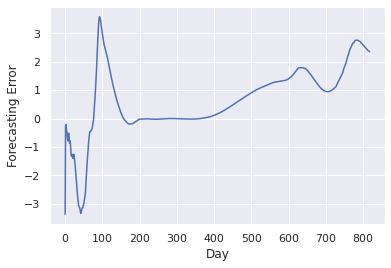

In [51]:
plt.plot(df2['days'],y_originalr2-ypredr2)  # y_originalb2 is the outcome and ypredb2 is the predicted outcome (on the scale of log y)
plt.xlabel('Day')
plt.ylabel('Forecasting Error')

# Error rate comparison

In [58]:
# Part A error rate (MSE)
pah1 = np.square(np.subtract(y_original,ytest)).mean()
pah2 = np.square(np.subtract(y_original2,ytest2)).mean()
palr = np.square(np.subtract(y_originalr1,ytestr1)).mean()

# Part B error rate (MSE)
pbh1 = np.square(np.subtract(y_originalb1,ypredb1)).mean()
pbh2 = np.square(np.subtract(y_originalb2,ypredb2)).mean()
pblr = np.square(np.subtract(y_originalr2,ypredr2)).mean()

In [59]:
error = {'Model':['PartA 1 hidden Layer', 'PartA 2 hidden Layers', 'PartA Regression', 'PartB 1 hidden Layer',
                  'PartB 2 hidden Layers', 'PartB Regression'],
         'Error rate(MSE)':[pah1,pah2,palr,pbh1,pbh2,pblr]}
error_df = pd.DataFrame(error)
error_df

,Model,Error rate(MSE)
0,PartA 1 hidden Layer,89.004776
1,PartA 2 hidden Layers,0.747935
2,PartA Regression,62.221050
3,PartB 1 hidden Layer,84.515694
4,PartB 2 hidden Layers,1.343863
5,PartB Regression,1.826855


As we can see that with more hidden layers, the error becomes smaller. Regression may have larger errors when comparing with neural networks with more hidden layers.